In [57]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
from PIL import Image, ImageFile
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [59]:
# Configuration
config = {
    "dataset_dir": r"D:\\PFE\\Datasets\\ForClassification\\wfd_dataset2020",
    "batch_size": 32,
    "num_epochs": 40,
    "learning_rate": 3e-4,
    "weight_decay": 1e-5,
    "num_classes": 7,
    "image_size": 224,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}


In [62]:
# Set up logging
import logging
logging.basicConfig(level=logging.INFO)
def log(message):
    print(f"[INFO] {message}")

# Custom ImageFolder class to handle corrupted files
class SafeImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        try:
            return super(SafeImageFolder, self).__getitem__(index)
        except (IOError, OSError, ValueError) as e:
            logging.warning(f"Skipping corrupted file at index {index}. Error: {e}")
            return None
# Function to filter out None samples from a dataset
def filter_corrupted_files(dataset):
    valid_samples = []
    for i in range(len(dataset)):
        try:
            sample = dataset[i]
            if sample is not None:
                valid_samples.append(sample)
        except Exception as e:
            logging.warning(f"Skipping corrupted data at index {i}: {e}")
    return valid_samples



In [63]:
# Data Augmentation and Preprocessing
train_transform = transforms.Compose([
    transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
    transforms.Resize((config["image_size"], config["image_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((config["image_size"], config["image_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [40]:
print ("ok")

ok


In [13]:
from PIL import Image
import os

dataset_path = r"D:\\PFE\\Datasets\\ForClassification\\wfd_dataset2020"  # Replace with the path to your dataset

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            img = Image.open(file_path)
            img.verify()  # Check if the file is corrupted
        except (IOError, SyntaxError) as e:
            print(f"Corrupted file: {file_path}")
            os.remove(file_path)  # Remove the corrupted file if necessary


Corrupted file: D:\\PFE\\Datasets\\ForClassification\\wfd_dataset2020\test\seedlings\desktop.ini


In [64]:
# Load datasets
train_dataset_raw = SafeImageFolder(os.path.join(config["dataset_dir"], "train"), transform=train_transform)
valid_dataset_raw = SafeImageFolder(os.path.join(config["dataset_dir"], "valid"), transform=test_transform)
test_dataset_raw = SafeImageFolder(os.path.join(config["dataset_dir"], "test"), transform=test_transform)

# Filter corrupted files
train_dataset = filter_corrupted_files(train_dataset_raw)
valid_dataset = filter_corrupted_files(valid_dataset_raw)
test_dataset = filter_corrupted_files(test_dataset_raw)

log(f"Filtered Train dataset: {len(train_dataset)} valid images")
log(f"Filtered Validation dataset: {len(valid_dataset)} valid images")
log(f"Filtered Test dataset: {len(test_dataset)} valid images")
log(f"Classes: {train_dataset_raw.classes}")

[INFO] Filtered Train dataset: 1890 valid images
[INFO] Filtered Validation dataset: 628 valid images
[INFO] Filtered Test dataset: 629 valid images
[INFO] Classes: ['healthy', 'leaf_rust', 'powdery_mildew', 'seedlings', 'septoria', 'stem_rust', 'yellow_rust']


In [65]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=4)

In [66]:
# Model Architecture
class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=7):
        super(EfficientNetB0, self).__init__()
        self.base_model = models.efficientnet_b0(pretrained=True)
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(self.base_model.classifier[1].in_features, num_classes),
        )

    def forward(self, x):
        return self.base_model(x)

# Initialize model, loss, optimizer, and scheduler
model = EfficientNetB0(num_classes=config["num_classes"]).to(config["device"])
log(f"Model loaded on {config['device']}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config["learning_rate"], steps_per_epoch=len(train_loader), epochs=config["num_epochs"])


[INFO] Model loaded on cpu


In [73]:
# Training Function
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, device, num_epochs):
    best_val_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()
        log(f"Epoch {epoch+1}, Train Loss: {running_loss / len(train_loader):.4f}")

        # Validation
        val_accuracy, val_f1, val_precision, val_recall = evaluate_model(model, valid_loader, device)
        log(f"Validation Accuracy: {val_accuracy:.4f}, F1-Score: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

        # Save best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), "best_model.pth")
            log(f"New best model saved with accuracy: {best_val_accuracy:.4f}")


In [74]:
# Evaluation Function
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=train_dataset_raw.classes, yticklabels=train_dataset_raw.classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, f1, precision, recall



In [72]:
log("Starting training...")

[INFO] Starting training...


Epoch 1/40: 100%|████████████████████████████████████████████████████████████████████| 60/60 [1:37:23<00:00, 97.39s/it]


[INFO] Epoch 1, Train Loss: 1.8741


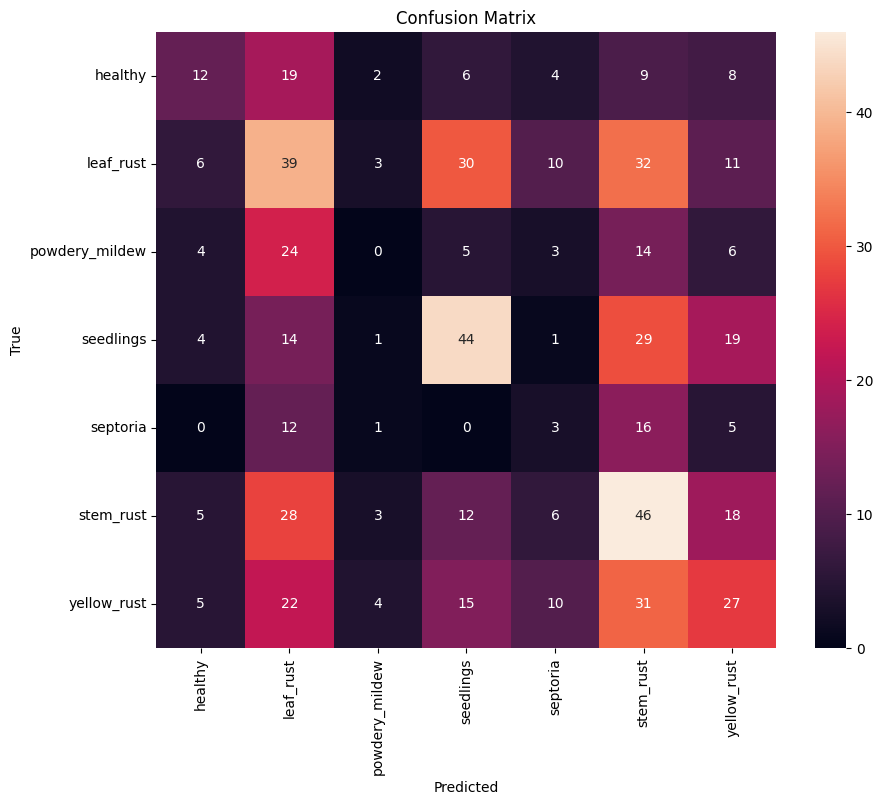

[INFO] Validation Accuracy: 0.2723, F1-Score: 0.2608, Precision: 0.2592, Recall: 0.2723
[INFO] New best model saved with accuracy: 0.2723


Epoch 2/40: 100%|████████████████████████████████████████████████████████████████████| 60/60 [1:23:42<00:00, 83.71s/it]


[INFO] Epoch 2, Train Loss: 1.8196


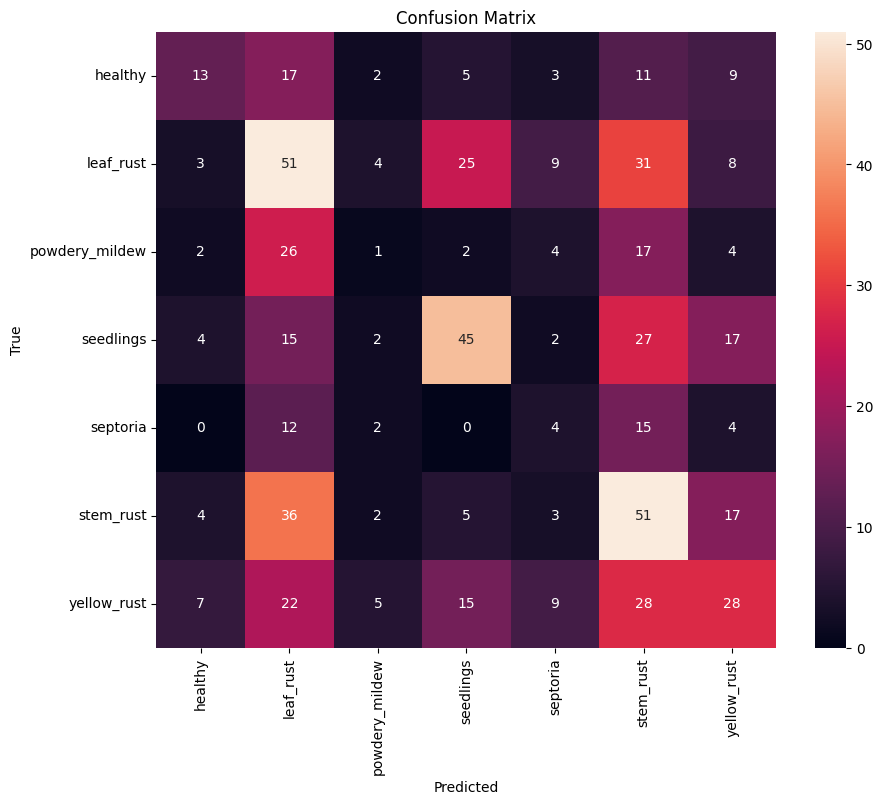

[INFO] Validation Accuracy: 0.3073, F1-Score: 0.2961, Precision: 0.3034, Recall: 0.3073
[INFO] New best model saved with accuracy: 0.3073


Epoch 3/40: 100%|████████████████████████████████████████████████████████████████████| 60/60 [1:12:49<00:00, 72.82s/it]


[INFO] Epoch 3, Train Loss: 1.7687


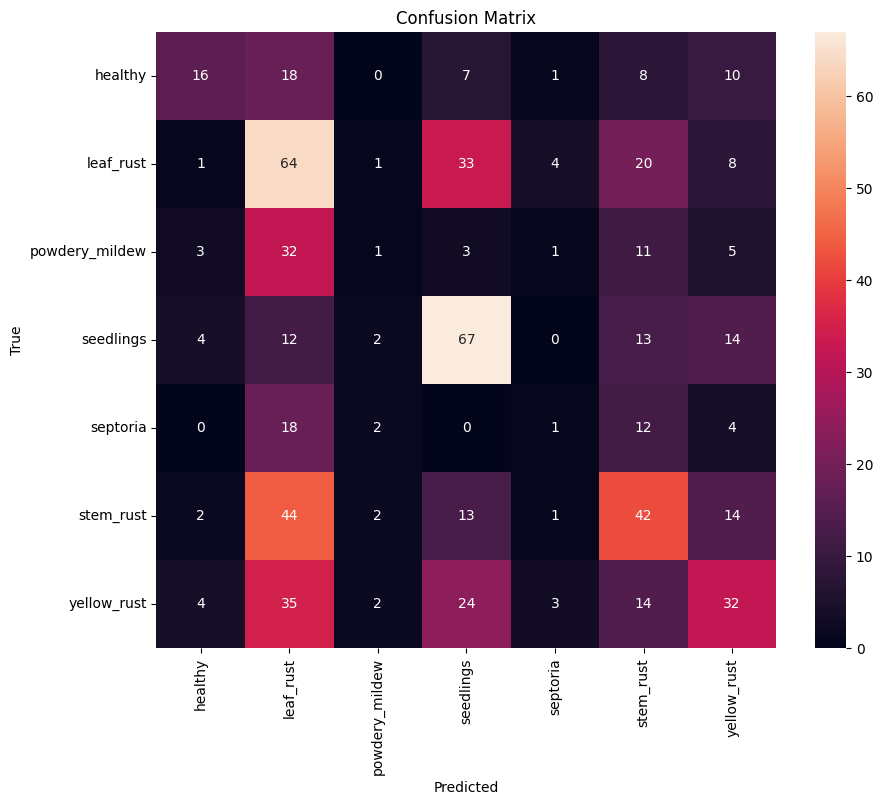

[INFO] Validation Accuracy: 0.3551, F1-Score: 0.3309, Precision: 0.3389, Recall: 0.3551
[INFO] New best model saved with accuracy: 0.3551


Epoch 4/40: 100%|████████████████████████████████████████████████████████████████████| 60/60 [1:04:29<00:00, 64.49s/it]


[INFO] Epoch 4, Train Loss: 1.7162


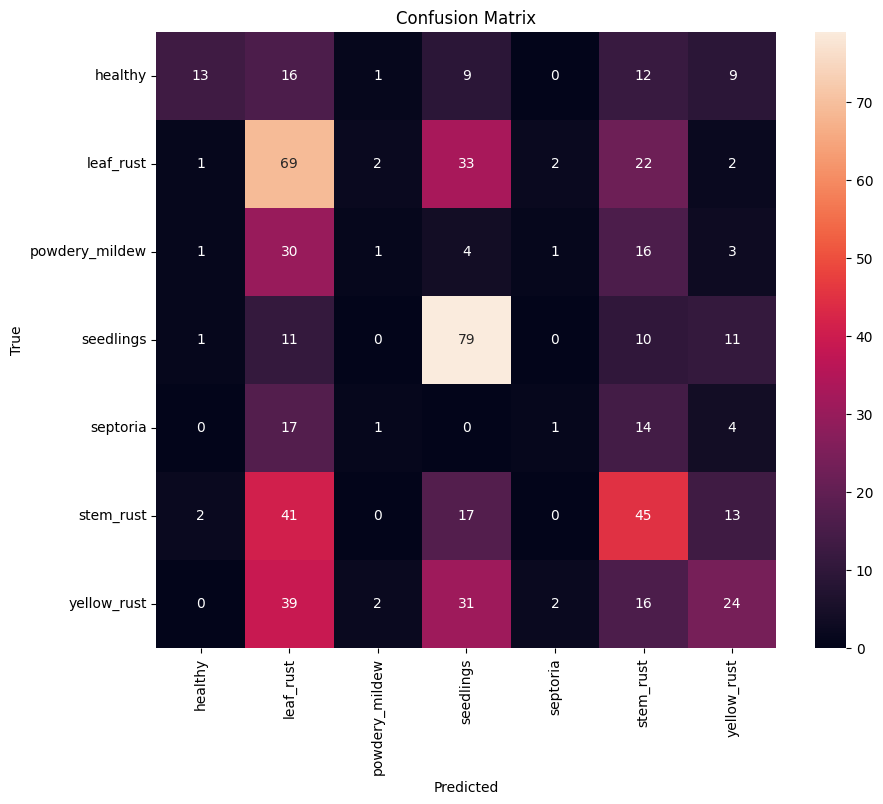

[INFO] Validation Accuracy: 0.3694, F1-Score: 0.3329, Precision: 0.3662, Recall: 0.3694
[INFO] New best model saved with accuracy: 0.3694


Epoch 5/40: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [29:24<00:00, 29.41s/it]


[INFO] Epoch 5, Train Loss: 1.6597


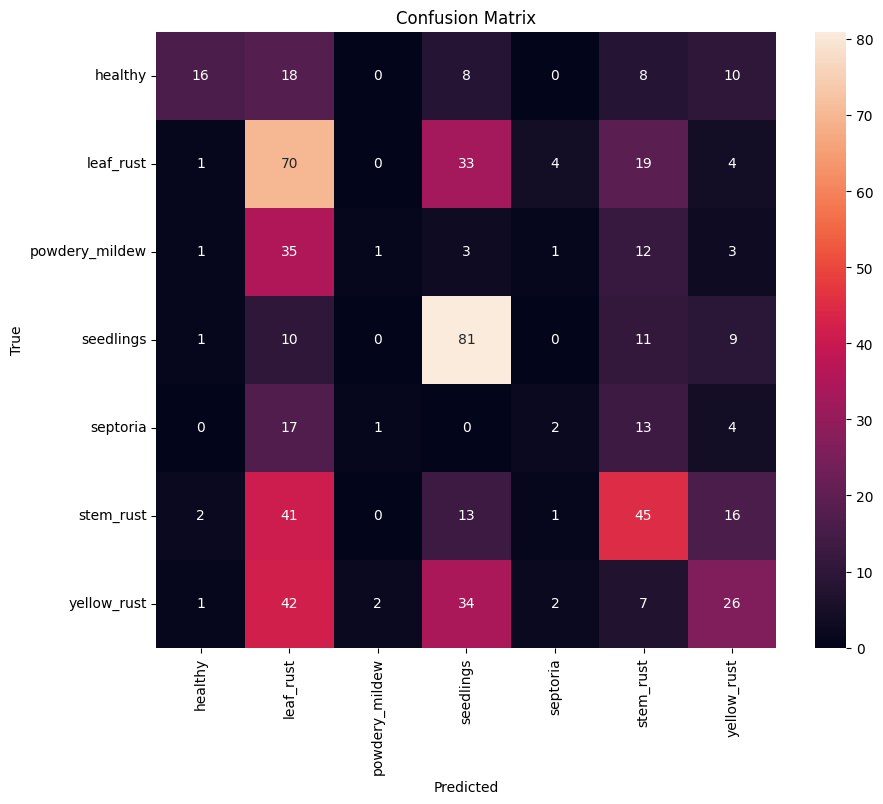

[INFO] Validation Accuracy: 0.3838, F1-Score: 0.3506, Precision: 0.3893, Recall: 0.3838
[INFO] New best model saved with accuracy: 0.3838


Epoch 6/40: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [37:27<00:00, 37.46s/it]


[INFO] Epoch 6, Train Loss: 1.6115


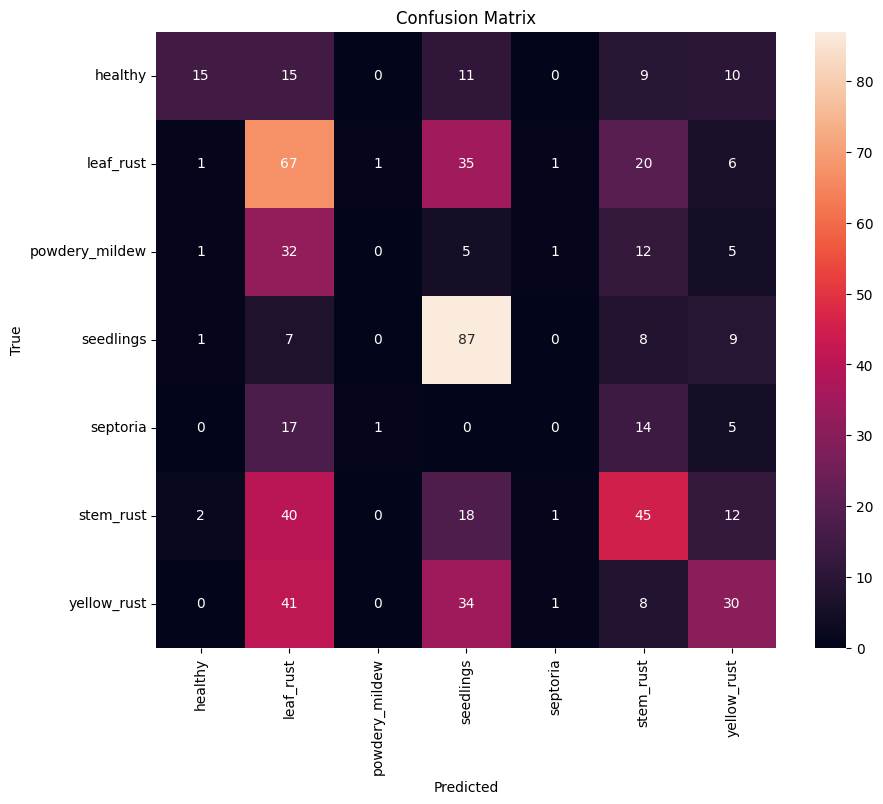

[INFO] Validation Accuracy: 0.3885, F1-Score: 0.3477, Precision: 0.3608, Recall: 0.3885
[INFO] New best model saved with accuracy: 0.3885


Epoch 7/40: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [31:16<00:00, 31.28s/it]


[INFO] Epoch 7, Train Loss: 1.5665


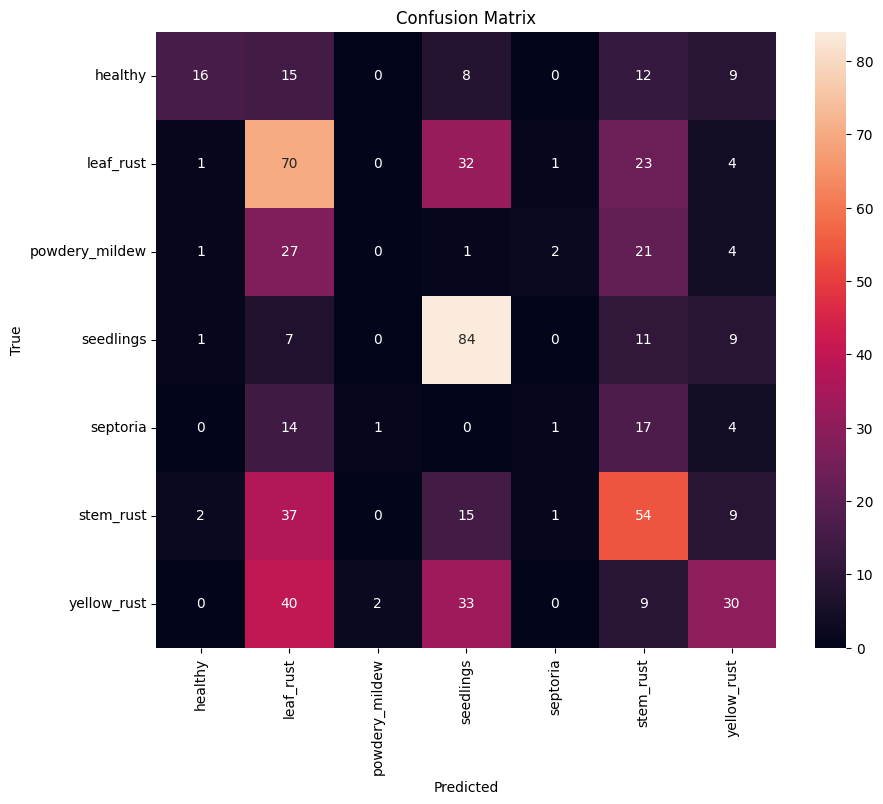

[INFO] Validation Accuracy: 0.4061, F1-Score: 0.3674, Precision: 0.3887, Recall: 0.4061
[INFO] New best model saved with accuracy: 0.4061


Epoch 8/40: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [30:20<00:00, 30.35s/it]


[INFO] Epoch 8, Train Loss: 1.5112


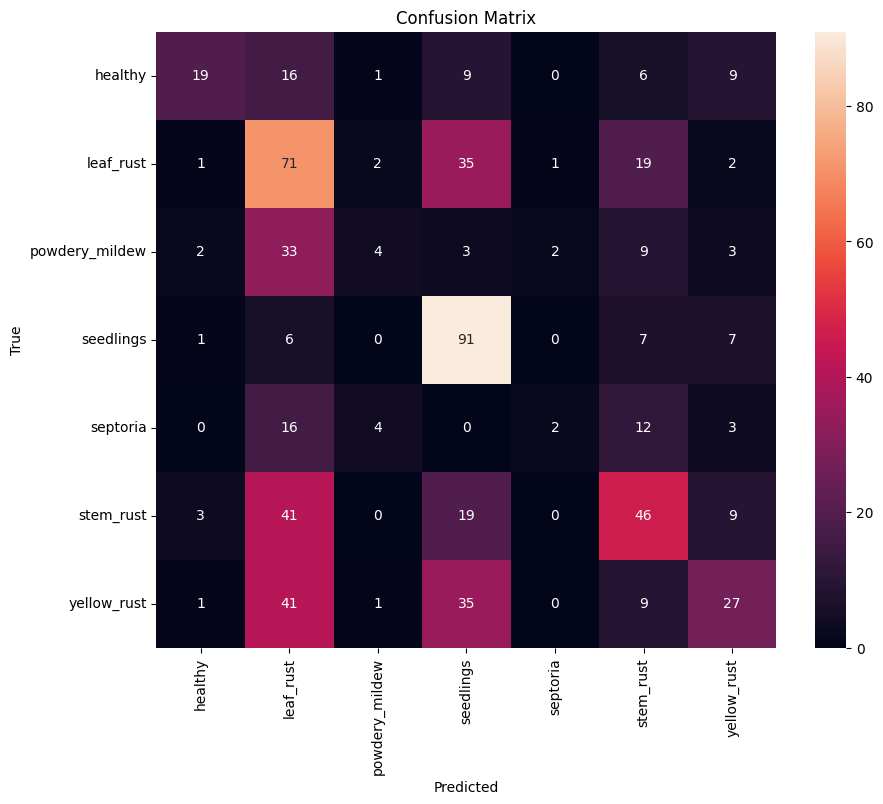

[INFO] Validation Accuracy: 0.4140, F1-Score: 0.3809, Precision: 0.4329, Recall: 0.4140
[INFO] New best model saved with accuracy: 0.4140


Epoch 9/40: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [28:54<00:00, 28.92s/it]


[INFO] Epoch 9, Train Loss: 1.4789


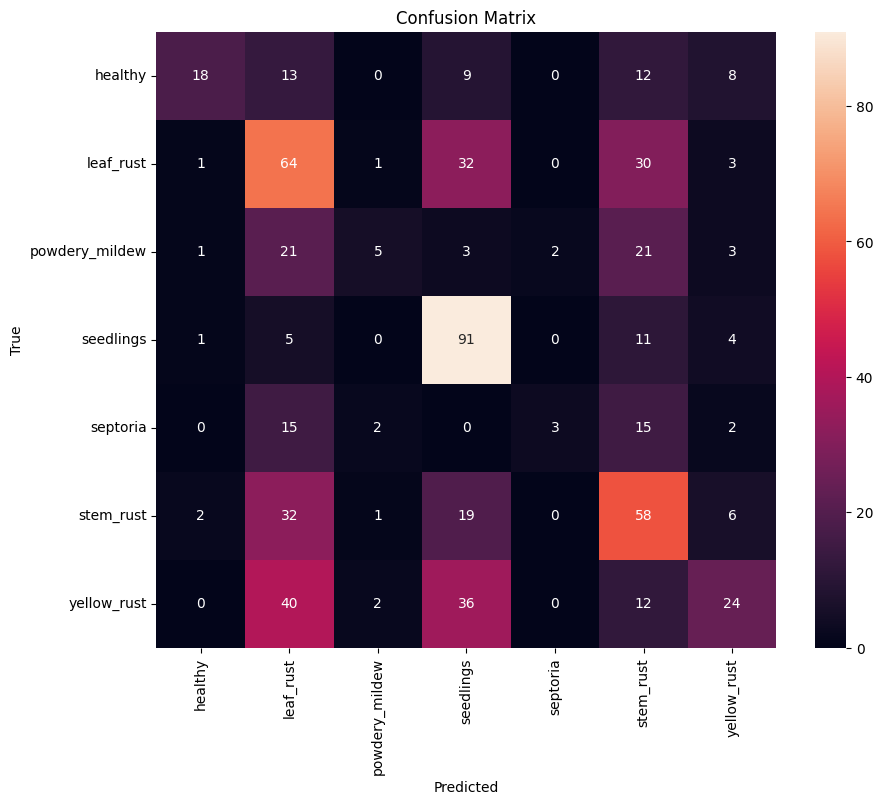

[INFO] Validation Accuracy: 0.4188, F1-Score: 0.3856, Precision: 0.4620, Recall: 0.4188
[INFO] New best model saved with accuracy: 0.4188


Epoch 10/40: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [28:49<00:00, 28.82s/it]


[INFO] Epoch 10, Train Loss: 1.4320


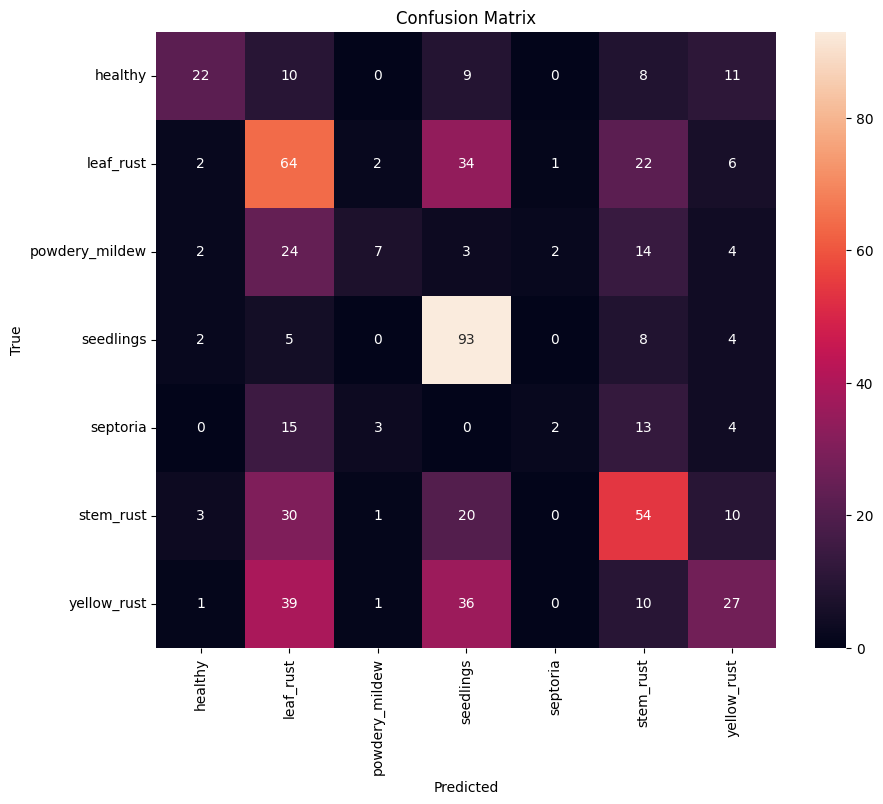

[INFO] Validation Accuracy: 0.4283, F1-Score: 0.3978, Precision: 0.4432, Recall: 0.4283
[INFO] New best model saved with accuracy: 0.4283


Epoch 11/40: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [28:07<00:00, 28.13s/it]


[INFO] Epoch 11, Train Loss: 1.3801


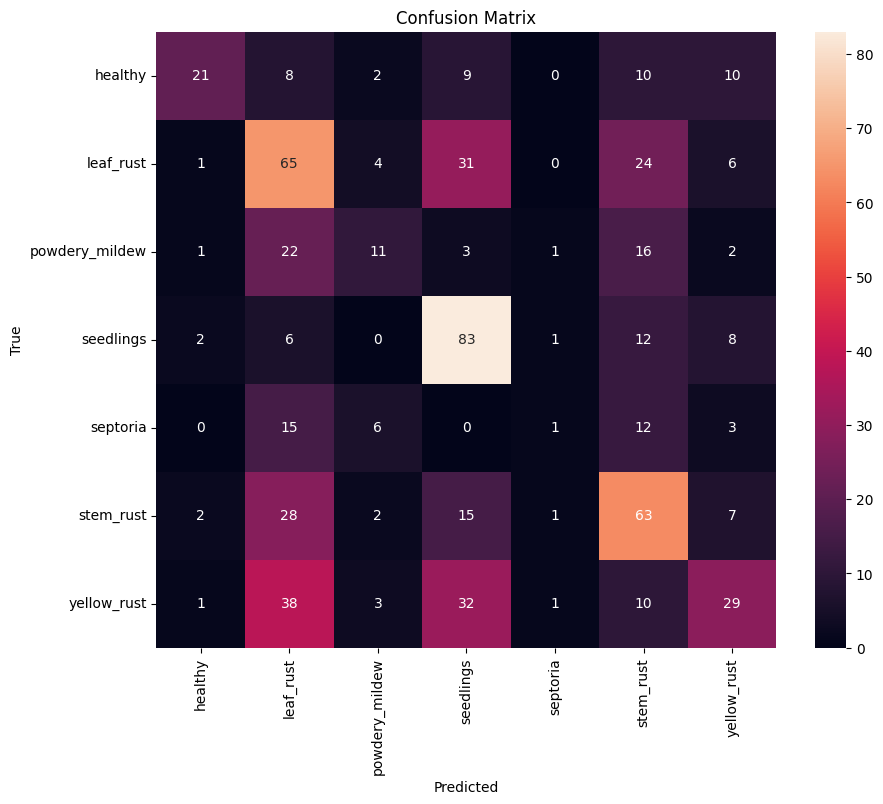

[INFO] Validation Accuracy: 0.4347, F1-Score: 0.4104, Precision: 0.4401, Recall: 0.4347
[INFO] New best model saved with accuracy: 0.4347


Epoch 12/40: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [35:44<00:00, 35.75s/it]


[INFO] Epoch 12, Train Loss: 1.3536


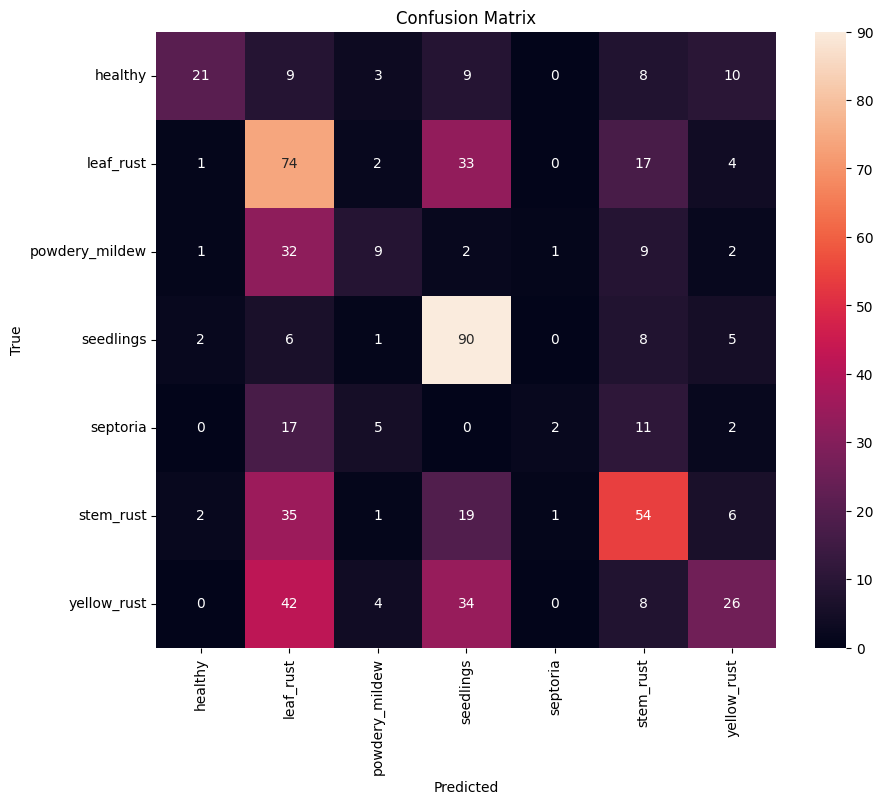

[INFO] Validation Accuracy: 0.4395, F1-Score: 0.4112, Precision: 0.4675, Recall: 0.4395
[INFO] New best model saved with accuracy: 0.4395


Epoch 13/40: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [28:13<00:00, 28.23s/it]


[INFO] Epoch 13, Train Loss: 1.3082


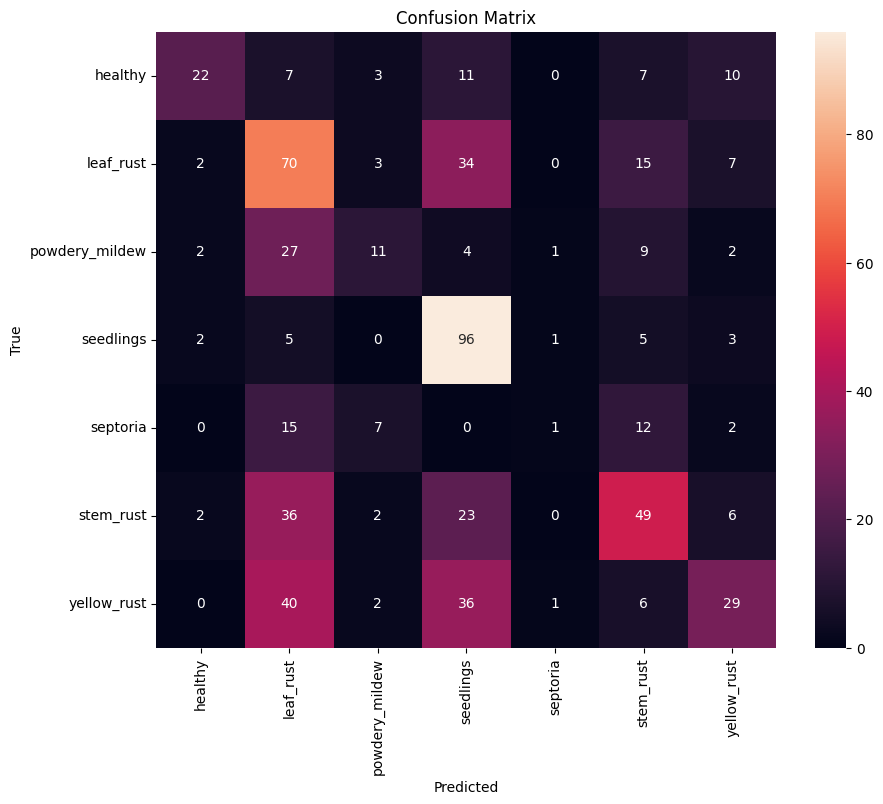

[INFO] Validation Accuracy: 0.4427, F1-Score: 0.4137, Precision: 0.4554, Recall: 0.4427
[INFO] New best model saved with accuracy: 0.4427


Epoch 14/40: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [32:27<00:00, 32.46s/it]


[INFO] Epoch 14, Train Loss: 1.2568


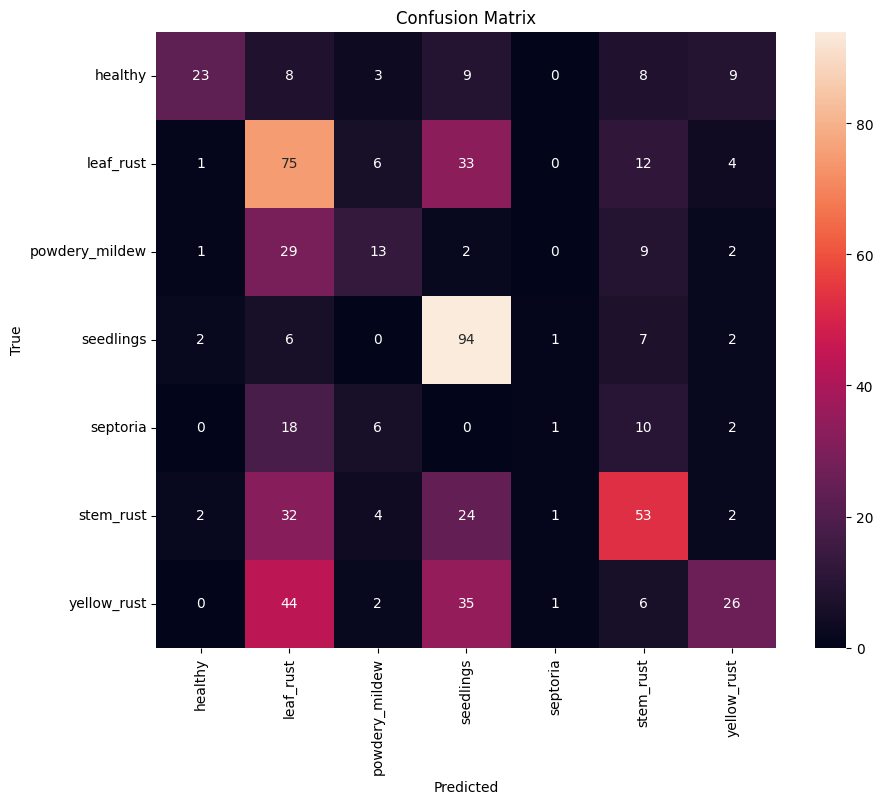

[INFO] Validation Accuracy: 0.4538, F1-Score: 0.4257, Precision: 0.4788, Recall: 0.4538
[INFO] New best model saved with accuracy: 0.4538


Epoch 15/40: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [27:30<00:00, 27.51s/it]


[INFO] Epoch 15, Train Loss: 1.2327


C:\Users\DELL\Desktop\PFETesting\paper1\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


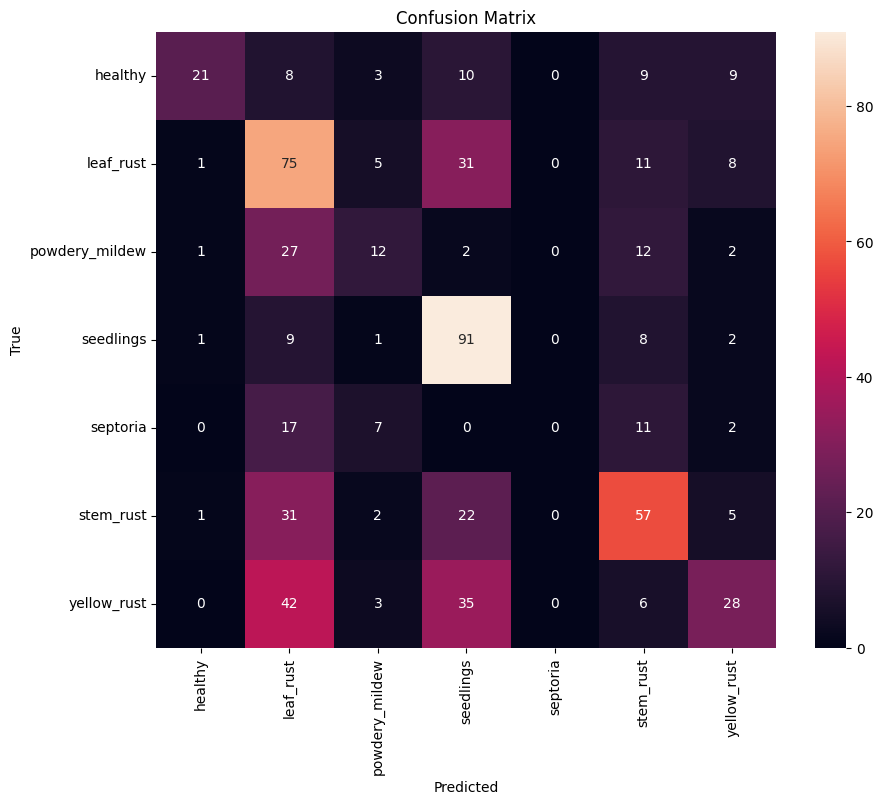

[INFO] Validation Accuracy: 0.4522, F1-Score: 0.4225, Precision: 0.4572, Recall: 0.4522


Epoch 16/40: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [25:48<00:00, 25.80s/it]


[INFO] Epoch 16, Train Loss: 1.1817


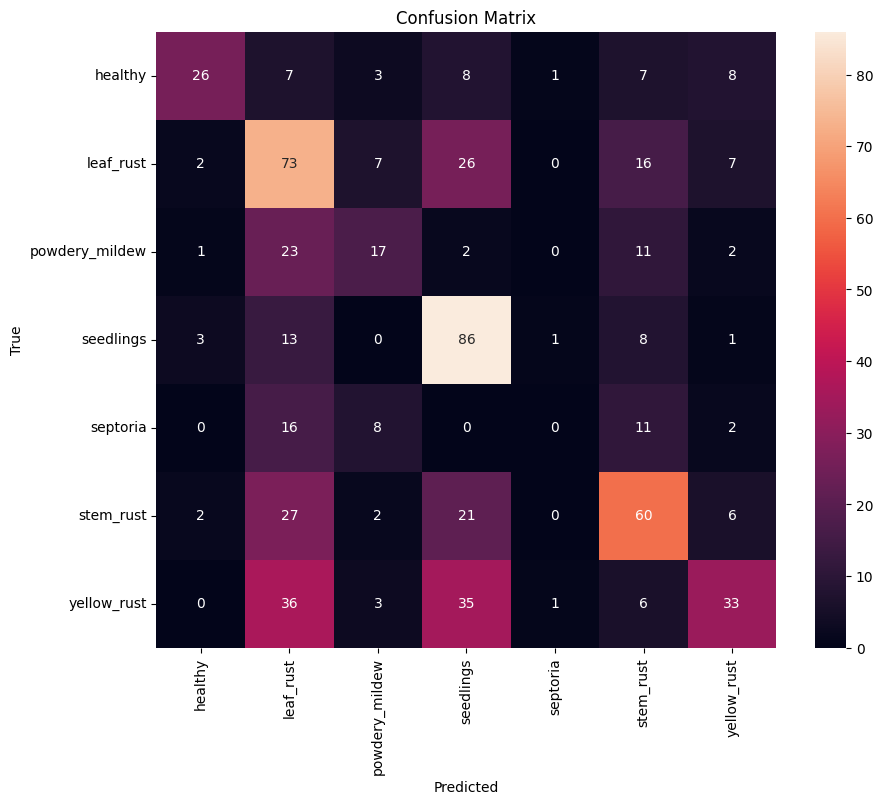

[INFO] Validation Accuracy: 0.4697, F1-Score: 0.4480, Precision: 0.4715, Recall: 0.4697
[INFO] New best model saved with accuracy: 0.4697


Epoch 17/40: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [31:09<00:00, 31.16s/it]


[INFO] Epoch 17, Train Loss: 1.1571


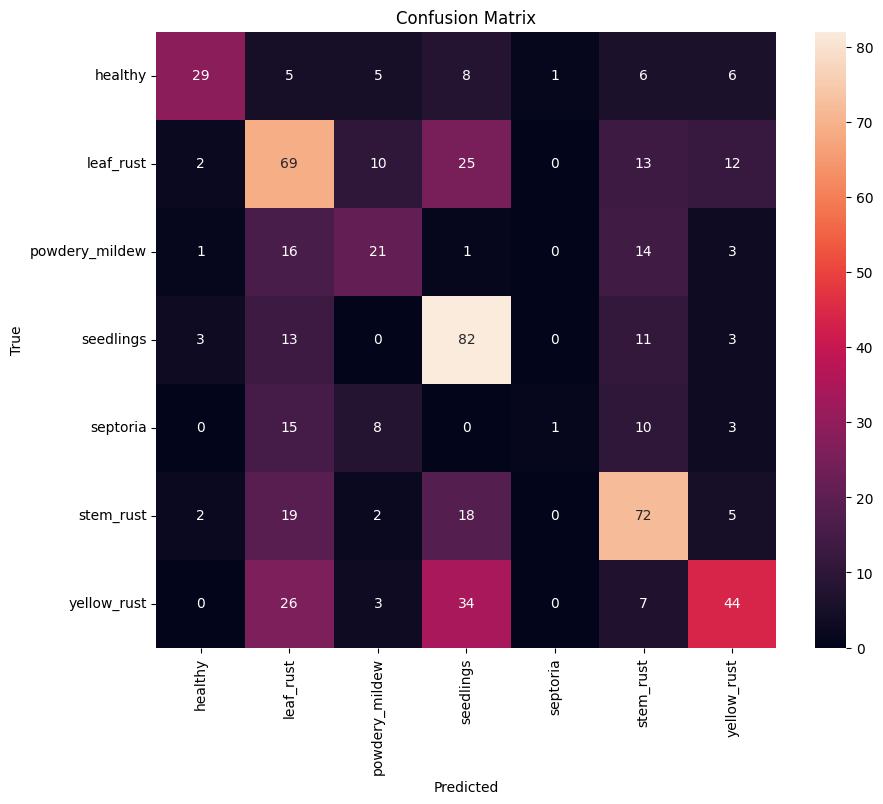

[INFO] Validation Accuracy: 0.5064, F1-Score: 0.4901, Precision: 0.5247, Recall: 0.5064
[INFO] New best model saved with accuracy: 0.5064


Epoch 18/40: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [47:43<00:00, 47.72s/it]


[INFO] Epoch 18, Train Loss: 1.1181


C:\Users\DELL\Desktop\PFETesting\paper1\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


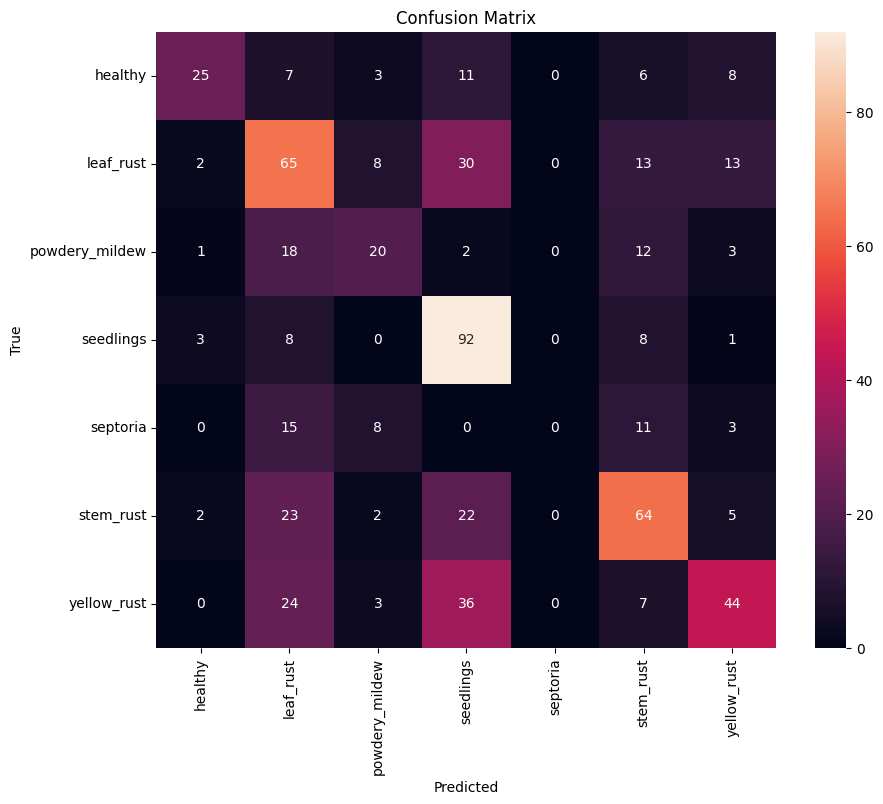

[INFO] Validation Accuracy: 0.4936, F1-Score: 0.4721, Precision: 0.4858, Recall: 0.4936


Epoch 19/40: 100%|███████████████████████████████████████████████████████████████████| 60/60 [1:02:44<00:00, 62.74s/it]


[INFO] Epoch 19, Train Loss: 1.0967


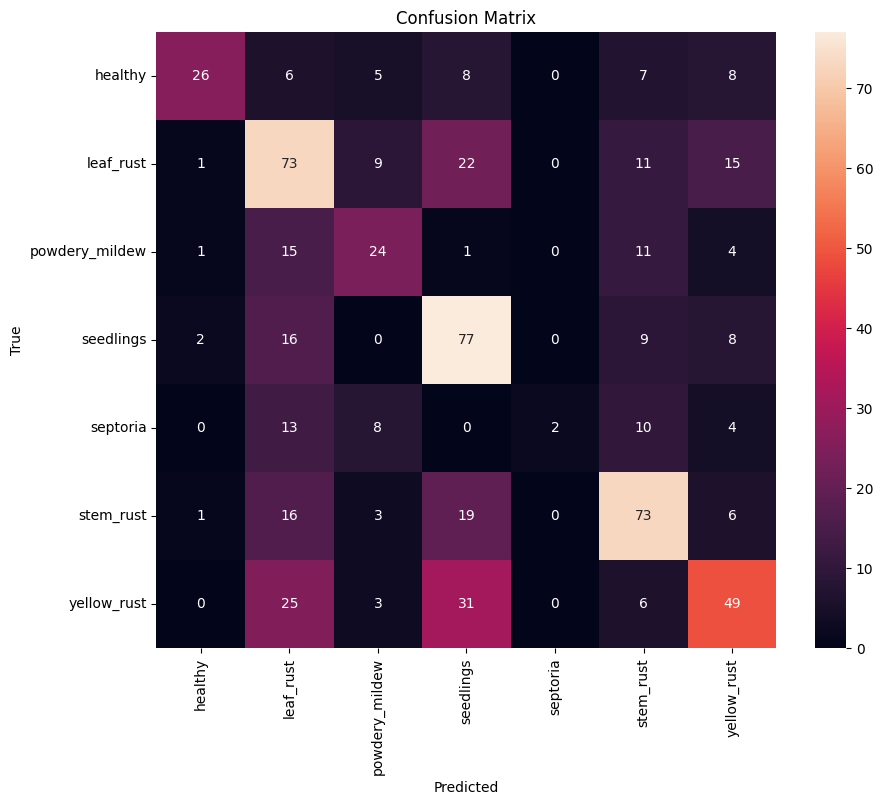

[INFO] Validation Accuracy: 0.5159, F1-Score: 0.5027, Precision: 0.5626, Recall: 0.5159
[INFO] New best model saved with accuracy: 0.5159


Epoch 20/40: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [47:02<00:00, 47.04s/it]


[INFO] Epoch 20, Train Loss: 1.0553


In [ ]:
# Train the model
train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, config["device"], config["num_epochs"])

In [45]:
# Evaluation Function
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, f1, precision, recall



In [46]:
log("Starting training...")

[INFO] Starting training...


In [ ]:
 train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, config["device"], config["num_epochs"])

Epoch 1/50:   0%|                                                                               | 0/60 [00:00<?, ?it/s]

In [ ]:
# Evaluate on test set
test_accuracy, test_f1, test_precision, test_recall = evaluate_model(model, test_loader, config["device"])
print(f"Test Accuracy: {test_accuracy:.4f}, F1-Score: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")

if test_accuracy >= 0.98:
    print("Target accuracy achieved! Model is performing well.")
else:
    print("Target accuracy not achieved. Consider tuning hyperparameters or improving the dataset.")

In [ ]:
# Save the final model
torch.save(model.state_dict(), "final_model.pth")
print("Final model saved.")